In [23]:
import os

import tensorflow as tf
import tensorflow_gnn as tfgnn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx


# Import the Data

We're going 

In [16]:
!wget https://www.chrsmrrs.com/graphkerneldatasets/COLLAB.zip 

!tar -xf COLLAB.zip

--2023-10-09 13:09:17--  https://www.chrsmrrs.com/graphkerneldatasets/COLLAB.zip
Resolving www.chrsmrrs.com (www.chrsmrrs.com)... 2001:8d8:100f:f000::258, 217.160.0.75
Connecting to www.chrsmrrs.com (www.chrsmrrs.com)|2001:8d8:100f:f000::258|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74427494 (71M) [application/zip]
Saving to: 'COLLAB.zip.1'

     0K .......... .......... .......... .......... ..........  0%  164K 7m24s
    50K .......... .......... .......... .......... ..........  0%  361K 5m22s
   100K .......... .......... .......... .......... ..........  0%  513K 4m22s
   150K .......... .......... .......... .......... ..........  0%  717K 3m42s
   200K .......... .......... .......... .......... ..........  0%  792K 3m15s
   250K .......... .......... .......... .......... ..........  0%  599K 3m3s
   300K .......... .......... .......... .......... ..........  0% 1.12M 2m46s
   350K .......... .......... .......... .......... ..........  0% 1.25M

# Graph Labels 

The COLLAB is a widely used benchmark dataset for graph neural networks. It maps the collaboration networks of researchers, labeling the networks as either 0: High Energy Physics, 1: Condensed Matter Physics, or 2: Astro Physics, depending on which field the researcher belongs to. 

In [46]:
edges = pd.read_csv('COLLAB/COLLAB_A.txt', sep=',',header=None)

print(edges.head())

graph_groups = pd.read_csv('COLLAB/COLLAB_graph_indicator.txt', header=None)

print(graph_groups.head())
graph_groups.rename({0:'graph'},axis=1, inplace=True)

grouped_edges = pd.merge(edges, graph_groups, left_index=True, right_index=True)
grouped_edges.rename({0:'source',1:'target'}, axis=1, inplace=True)
print(grouped_edges.head())



   0  1
0  1  2
1  2  1
2  1  3
3  3  1
4  1  4
   0
0  1
1  1
2  1
3  1
4  1
   source  target  graph
0       1       2      1
1       2       1      1
2       1       3      1
3       3       1      1
4       1       4      1


In [67]:
graphs = []

for i in range(5000):
   el = grouped_edges[grouped_edges.graph == i+1]
   G = nx.from_pandas_edgelist(el, source='source',target='target')
   graphs.append(G)



Graph with 24 nodes and 23 edges


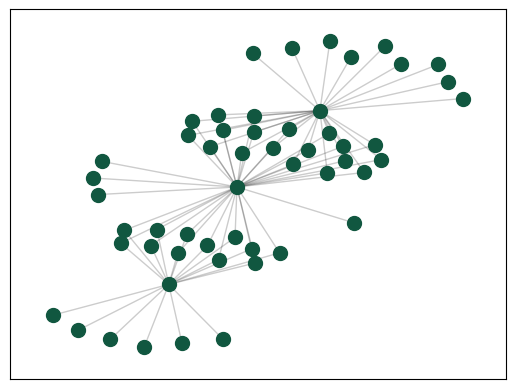

In [71]:
print(graphs[0])

GG=graphs[3500]

pos = nx.spring_layout(GG, seed=1987)

nx.draw_networkx_edges(GG, pos, alpha=0.2)
nx.draw_networkx_nodes(GG, pos, nodelist=GG.nodes(),
                       node_color='#115740', node_size=100)

In [77]:
graph_labels = pd.read_csv('COLLAB/COLLAB_graph_labels.txt', header=None)
graph_labels.rename({0:'labels'}, axis=1, inplace=True)

print(graph_labels.head())

   labels
0       1
1       1
2       1
3       1
4       1


In [86]:
graph_tensor = tfgnn.GraphTensor.from_pieces(
   context = tfgnn.Context.from_fields(
      features={'labels': graph_labels['labels']}),
   node_sets= {'node': tfgnn.NodeSet.from_fields(sizes=[len(grouped_edges)], features={})},
   edge_sets= {
        'edge': tfgnn.EdgeSet.from_fields(
            sizes=[len(grouped_edges)],
            features={},
            adjacency=tfgnn.Adjacency.from_indices(
                source=('node', grouped_edges['source']),
                target=('node', grouped_edges['target'])))})


In [87]:
def decode_fn(record_bytes):
  graph = tfgnn.parse_single_example(
      graph_tensor_spec, record_bytes, validate=True)

  # extract label from context and remove from input graph
  context_features = graph.context.get_features_dict()
  label = context_features.pop('label')
  new_graph = graph.replace_features(context=context_features)

  return new_graph, label



GraphTensor(
  context=Context(features={'labels': <tf.Tensor: shape=(5000,), dtype=tf.int64>}, sizes=[1], shape=(), indices_dtype=tf.int32),
  node_set_names=['node'],
  edge_set_names=['edge'])
